# 무역 데이터 EDA (HS4 / item_id 단위 EDA 및 micro-level deep dive)

In [51]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns


df_train = pd.read_csv('C:/Users/ujy22/kmu_competition/open/train.csv')
print(df_train.head(20))

     item_id  year  month  seq  type   hs4      weight  quantity       value
0   DEWLVASR  2022      1  1.0     1  3038     14858.0       0.0     32688.0
1   ELQGMQWE  2022      1  1.0     1  2002     62195.0       0.0    110617.0
2   AHMDUILJ  2022      1  1.0     1  2102     18426.0       0.0     72766.0
3   XIPPENFQ  2022      1  1.0     1  2501     20426.0       0.0     11172.0
4   FTSVTTSR  2022      1  1.0     1  2529    248000.0       0.0    143004.0
5   XMKRPGLB  2022      1  1.0     1  2529    558000.0       0.0    205676.0
6   RCBZUSIM  2022      1  1.0     1  2805         0.0       0.0       459.0
7   SUOYXCHP  2022      1  1.0     1  2805         0.0       0.0       482.0
8   ZKENOUDA  2022      1  1.0     1  2805         2.0       0.0      2783.0
9   WQMVCOEM  2022      1  1.0     1  2805       187.0       0.0    217777.0
10  BSRMSVTC  2022      1  1.0     1  2805       111.0       0.0     33952.0
11  DDEXPPXU  2022      1  1.0     1  2807       387.0       0.0     13158.0

## 1. 전처리

- zero / missing flag 생성:
  - value, weight, quantity의 0은 정상적일 수 있음 👉 제거 X
  - 대신 zero 패턴 자체를 feature로 인식하기 위해 flag 생성.

- 결측치 처리:
  - weight, quantity, value 결측은 보간하지 않음 (의미 있는 결측이기 때문)

- item_id / HS4 단위 monthly pivot 생성
  - → Comovement 분석의 기본 단위로 사용될 시계열 구조 확보.

In [52]:
# Zero flag 생성
df_train['value_zero'] = (df_train['value'] == 0).astype(int)
df_train['weight_zero'] = (df_train['weight'] == 0).astype(int)
df_train['quantity_zero'] = (df_train['quantity'] == 0).astype(int)

# Missing flag 생성
df_train['value_missing'] = df_train['value'].isna().astype(int)
df_train['weight_missing'] = df_train['weight'].isna().astype(int)
df_train['quantity_missing'] = df_train['quantity'].isna().astype(int)

In [53]:
hs2_map = {
    "01": "산동물",
    "02": "육과 식용설육",
    "03": "어패류",
    "04": "낙농품·조란·천연동물성 식품",
    "05": "기타 동물성 생산품",
    "06": "산수목·꽃",
    "07": "채소",
    "08": "과실·견과류",
    "09": "커피·향신료",

    "10": "곡물",
    "11": "밀가루·전분",
    "12": "채유용 종자·인삼",
    "13": "식물성 엑스",
    "14": "기타 식물성 생산품",
    "15": "동식물성 유지",
    "16": "육·어류 조제품",
    "17": "당류·설탕과자",
    "18": "코코아·초콜릿",
    "19": "곡물·곡분 주제품·빵류",

    "20": "채소·과실의 조제품",
    "21": "기타 조제식료품",
    "22": "음료·주류·식초",
    "23": "조제사료",
    "24": "담배",
    "25": "토석류·소금",
    "26": "광·슬랙·회",
    "27": "광물성 연료·에너지",
    "28": "무기화합물",
    "29": "유기화합물",

    "30": "의료용품",
    "31": "비료",
    "32": "염료·안료·페인트·잉크",
    "33": "향료·화장품",
    "34": "비누·계면활성제·왁스",
    "35": "카세인·알부민·변성전분·효소",
    "36": "화약류·성냥",
    "37": "필름·인화지·사진용 재료",
    "38": "기타 화학공업 품목",
    "39": "플라스틱과 그 제품",

    "40": "고무와 그 제품",
    "41": "원피·가죽",
    "42": "가죽제품",
    "43": "모피·모피제품",
    "44": "목재·목탄",
    "45": "코르크·코르크 제품",
    "46": "조물재료 제품",
    "47": "펄프",
    "48": "지·판지",
    "49": "서적·신문·인쇄물",

    "50": "견·견사·견직물",
    "51": "양모·수모",
    "52": "면·면사·면직물",
    "53": "마류사·직물",
    "54": "인조 필라멘트 섬유",
    "55": "인조 스테이플 섬유",
    "56": "워딩·부직포",
    "57": "양탄자",
    "58": "특수 직물",
    "59": "침투·도포 직물",

    "60": "편물",
    "61": "의류(편물제)",
    "62": "의류(편물제 외)",
    "63": "기타 섬유제품·넝마",
    "64": "신발류",
    "65": "모자류",
    "66": "우산·지팡이",
    "67": "조제 우모·인조제품",
    "68": "석·시멘트·석면 제품",
    "69": "도자 제품",

    "70": "유리",
    "71": "귀석·반귀석·귀금속",
    "72": "철강",
    "73": "철강제품",
    "74": "동과 그 제품",
    "75": "니켈과 그 제품",
    "76": "알루미늄과 그 제품",
    "78": "연과 그 제품",
    "79": "아연과 그 제품",

    "80": "주석과 그 제품",
    "81": "기타 비금속",
    "82": "비금속 공구·스푼·포크",
    "83": "각종 비금속 제품",
    "84": "보일러·기계류",
    "85": "전기기기·TV·VTR",
    "86": "철도차량",
    "87": "일반차량",
    "88": "항공기",
    "89": "선박",

    "90": "광학·의료·측정·정밀기기",
    "91": "시계",
    "92": "악기",
    "93": "무기",
    "94": "가구·조명기구",
    "95": "완구·운동용품",
    "96": "잡품",
    "97": "예술품·골동품"
}


### 모든 item_id × 모든 month 패널 완성(Panel Completion)

현재 데이터는 모든 item_id가 모든 월에 등장하지 않음 → 공행성 분석에서 큰 문제됨.
동시에 존재하는 시계열끼리 비교해야 함

예:
- A item은 2022~2025 전 기간 존재
- B item은 특정 계절만 존재
- C item은 중간에 구멍 있음

이런 상태에서 comovement correlation 계산하면 시계열 길이가 불일치 → 오류 / 왜곡 발생, 상관계수 계산 불가<br>
- A : 2022.01 ~ 2025.07 모든 달에 존재 = 42개월
- C : 2022.03 ~ 2023.05 일부 달에 존재 = 15개월
→ 반드시 해야 하는 전처리:<br>
모든 item_id × 모든 month 조합을 만들고 없는 row는 0 또는 NaN으로 채우기

✅ 1단계: df_train에 date 컬럼 붙이기

아래 셀을 통째로 새로 실행해 줘:

✅ 2단계: panel(모든 item_id × 모든 month) 만들기

이제 date가 생겼다고 가정하고, 아래 셀 실행 👇

In [54]:
import pandas as pd

# ------------------------------------
# 0) date 컬럼 만들기 (year, month 기준)
# ------------------------------------
# year, month가 있고 date가 아직 없을 때만 생성
if "date" not in df_train.columns:
    df_train["date"] = pd.to_datetime(
        df_train["year"].astype(int).astype(str) + "-" +
        df_train["month"].astype(int).astype(str) + "-01"
    )

# 혹시 date가 object/string인 경우 datetime으로 변환
df_train["date"] = pd.to_datetime(df_train["date"])

# ------------------------------------
# 1) 월별 집계 (중복거래 제거 핵심)
#    item_id + hs4 + date 기준으로 value/weight/quantity 합산
# ------------------------------------
agg_cols = ["value", "weight", "quantity"]

df_train_monthly = (
    df_train
    .groupby(["item_id", "hs4", "date"], as_index=False)[agg_cols]
    .sum()
)

print("월별 집계 결과 예시:")
print(df_train_monthly.head())

# ------------------------------------
# 2) 전체 month 범위 & item_id 목록 만들기
# ------------------------------------
min_month = df_train_monthly["date"].min()
max_month = df_train_monthly["date"].max()

full_months = pd.date_range(min_month, max_month, freq="MS")
all_items = df_train_monthly["item_id"].unique()

# ------------------------------------
# 3) item_id × date 전체 조합 (풀 패널 인덱스)
# ------------------------------------
panel = pd.MultiIndex.from_product(
    [all_items, full_months],
    names=["item_id", "date"]
).to_frame(index=False)

# ------------------------------------
# 4) 집계된 df_train_monthly와 merge해서 패널 완성
# ------------------------------------
df_panel = (
    panel.merge(df_train_monthly, on=["item_id", "date"], how="left")
         .sort_values(["item_id", "date"])
         .reset_index(drop=True)
)

# 거래 없던 month → NaN을 0으로 채우기 (원하면)
for c in agg_cols:
    df_panel[c] = df_panel[c].fillna(0)

# 연/월 컬럼 다시 생성
df_panel["year"] = df_panel["date"].dt.year
df_panel["month"] = df_panel["date"].dt.month

print("최종 패널 예시:")
print(df_panel.head())

# 중복 체크 (item_id, date 조합이 유일한지)
print("중복 row 개수:", df_panel.duplicated(["item_id", "date"]).sum())


월별 집계 결과 예시:
    item_id   hs4       date    value    weight  quantity
0  AANGBULD  4810 2022-01-01  14276.0   17625.0       0.0
1  AANGBULD  4810 2022-02-01  52347.0   67983.0       0.0
2  AANGBULD  4810 2022-03-01  53549.0   69544.0       0.0
3  AANGBULD  4810 2022-05-01  26997.0   34173.0       0.0
4  AANGBULD  4810 2022-06-01  84489.0  103666.0       0.0
최종 패널 예시:
    item_id       date     hs4    value   weight  quantity  year  month
0  AANGBULD 2022-01-01  4810.0  14276.0  17625.0       0.0  2022      1
1  AANGBULD 2022-02-01  4810.0  52347.0  67983.0       0.0  2022      2
2  AANGBULD 2022-03-01  4810.0  53549.0  69544.0       0.0  2022      3
3  AANGBULD 2022-04-01     NaN      0.0      0.0       0.0  2022      4
4  AANGBULD 2022-05-01  4810.0  26997.0  34173.0       0.0  2022      5
중복 row 개수: 0


In [5]:
df_panel.duplicated(["item_id", "date"]).sum()

0

In [6]:
df_panel["hs2"] = df_panel["hs4"].astype(str).str[:2]
df_panel["hs2_name_kr"] = df_panel["hs2"].map(hs2_map)

In [7]:
#df_panel.isnull().sum()
#df_panel[df_panel['seq'].isnull()]

#df_panel.duplicated().sum()
df_panel.head()


,item_id,date,hs4,value,weight,quantity,year,month,hs2,hs2_name_kr
0,AANGBULD,2022-01-01,4810.0,14276.0,17625.0,0.0,2022,1,48,지·판지
1,AANGBULD,2022-02-01,4810.0,52347.0,67983.0,0.0,2022,2,48,지·판지
2,AANGBULD,2022-03-01,4810.0,53549.0,69544.0,0.0,2022,3,48,지·판지
3,AANGBULD,2022-04-01,NaN,0.0,0.0,0.0,2022,4,na,NaN
4,AANGBULD,2022-05-01,4810.0,26997.0,34173.0,0.0,2022,5,48,지·판지


In [8]:
# 거래량 관련 수치 컬럼
value_cols = ['value', 'weight', 'quantity']

# 없는 월은 거래 0으로 (너 프로젝트 설정에 따라 조정 가능)
#df_panel[value_cols] = df_panel[value_cols].fillna(0)

# zero / missing flag가 이미 df_train에 있다면 같이 채워주기
flag_cols = [
    'value_zero', 'weight_zero', 'quantity_zero',
    'value_missing', 'weight_missing', 'quantity_missing'
]

for c in flag_cols:
    if c in df_panel.columns:
        df_panel[c] = df_panel[c].fillna(0).astype(int)

df_panel.head()
df_panel[df_panel['item_id'] == 'GKQIJYDH']

,item_id,date,hs4,value,weight,quantity,year,month,hs2,hs2_name_kr
1247,GKQIJYDH,2022-01-01,8501.0,9782469.0,579404.0,68.0,2022,1,85,전기기기·TV·VTR
1248,GKQIJYDH,2022-02-01,8501.0,321176.0,50685.0,31.0,2022,2,85,전기기기·TV·VTR
1249,GKQIJYDH,2022-03-01,8501.0,7106218.0,416214.0,68.0,2022,3,85,전기기기·TV·VTR
1250,GKQIJYDH,2022-04-01,8501.0,17850488.0,854306.0,550.0,2022,4,85,전기기기·TV·VTR
1251,GKQIJYDH,2022-05-01,8501.0,41768869.0,3025992.0,181.0,2022,5,85,전기기기·TV·VTR
1252,GKQIJYDH,2022-06-01,8501.0,11677001.0,698063.0,125.0,2022,6,85,전기기기·TV·VTR
1253,GKQIJYDH,2022-07-01,8501.0,8420099.0,630011.0,88.0,2022,7,85,전기기기·TV·VTR
1254,GKQIJYDH,2022-08-01,8501.0,14228993.0,794488.0,108.0,2022,8,85,전기기기·TV·VTR
1255,GKQIJYDH,2022-09-01,8501.0,19845420.0,741487.0,110.0,2022,9,85,전기기기·TV·VTR
1256,GKQIJYDH,2022-10-01,8501.0,9518385.0,378466.0,123.0,2022,10,85,전기기기·TV·VTR


## 2. HS4 / item_id 군집성 분석

In [9]:
df = df_panel.copy() 

hs4_summary = (
    df.groupby("hs4")[["value", "weight"]]
      .mean()
      .reset_index()
      .sort_values("value", ascending=False)
)

hs4_summary.head(10)
# 어떤 HS4 품목군의 평균 거래금액과 평균 중량이 높은지 파악
# 품목군의 경제적 규모 이해

,hs4,value,weight
11,2814.0,5.999737e+07,1.022512e+08
54,6211.0,2.516274e+07,8.551477e+05
32,3824.0,2.459375e+07,8.139476e+06
23,3102.0,1.754666e+07,3.233097e+07
70,9403.0,1.721897e+07,6.029486e+06
65,8505.0,1.216691e+07,3.952844e+05
31,3815.0,1.050937e+07,9.385711e+05
63,8479.0,6.980014e+06,3.525974e+05
14,2836.0,6.607692e+06,2.160214e+07
64,8501.0,6.485218e+06,4.014716e+05


In [10]:

hs4_qty_rate = (
    df.assign(qty_valid=(df["quantity"] > 0))
      .groupby("hs4")["qty_valid"]
      .mean()
      .reset_index(name="quantity_usage_rate")
      .sort_values("quantity_usage_rate", ascending=False)
)

hs4_qty_rate.head(10)
# 어떤 HS4는 quantity가 자주 기록되지만
# 어떤 HS4는 quantity가 거의 0 또는 누락
# 품목군 특성 파악, 모델링 시 quantity를 feature로 사용할지 판단

,hs4,quantity_usage_rate
35,4202.0,1.0
62,8467.0,1.0
42,5111.0,1.0
45,5309.0,1.0
47,5512.0,1.0
48,5515.0,1.0
51,5705.0,1.0
53,6101.0,1.0
36,4302.0,1.0
61,8461.0,1.0


In [11]:
item_volume = (
    df.groupby("item_id")["value"]
      .sum()
      .reset_index()
      .sort_values("value", ascending=False)
)

top_items = item_volume.head(20)
bottom_items = item_volume.tail(20)

top_items, bottom_items

# 가장 거래규모가 큰 품목과 작은 품목
# 예측 우선순위 선정, 군집분석 시 중요


(     item_id         value
 21  FCYBOAXC  4.671997e+09
 4   ATLDMDBO  2.579887e+09
 31  GYHKIVQT  1.456760e+09
 12  CCLHWFWF  1.081998e+09
 74  STZDBITS  1.057606e+09
 45  LRVGFDFM  8.040184e+08
 11  BUZIIBYG  7.404158e+08
 10  BTMOEMEP  7.049946e+08
 29  GKQIJYDH  6.070892e+08
 72  SDWAYPIK  4.381489e+08
 88  WPQXWHYO  4.093971e+08
 42  KJNSOAHR  3.001406e+08
 17  DNMPSKTB  2.888946e+08
 33  HXYSSRXE  2.841308e+08
 48  LUENUFGA  2.756382e+08
 37  JPBRUTWP  2.664403e+08
 61  QRKRBYJL  2.214571e+08
 6   BEZYMBBT  2.123930e+08
 20  EVBVXETX  1.975996e+08
 94  XUOIQPFL  1.960189e+08,
      item_id     value
 14  DDEXPPXU  820507.0
 38  JSLXRQOK  651539.0
 34  IGDVVKUD  606705.0
 8   BLANHGYY  541289.0
 65  RCBZUSIM  540481.0
 58  PYZMVUWD  530103.0
 99  ZXERAXWP  485789.0
 2   ANWUJOKX  350309.0
 36  JERHKLYW  334445.0
 22  FDXPMYGF  219744.0
 51  NAQIHUKZ  202508.0
 27  FWUCPMMW   97723.0
 95  YSYHGLQK   95838.0
 28  GIKPEWTY   94461.0
 16  DJBLNPNC   85293.0
 57  PLMZALFA    5385.0
 76

In [12]:
item_month_coverage = (
    df.groupby("item_id")["date"]
      .nunique()
      .reset_index(name="month_covered")
      .sort_values("month_covered", ascending=False)
)

item_month_coverage.head()
# 모든 item_id가 모든 월에 등장하는지 확인
# 모든 월에 등장하는 item_id만 모델링에 활용

#item_month_coverage.tail()
# 모든 월에 등장하지 않는 item_id는 모델링에서 제외


,item_id,month_covered
0,AANGBULD,43
63,QVLMOEYE,43
73,SNHYOVBM,43
72,SDWAYPIK,43
71,SAHWCZNH,43


C:\Users\ujy22\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


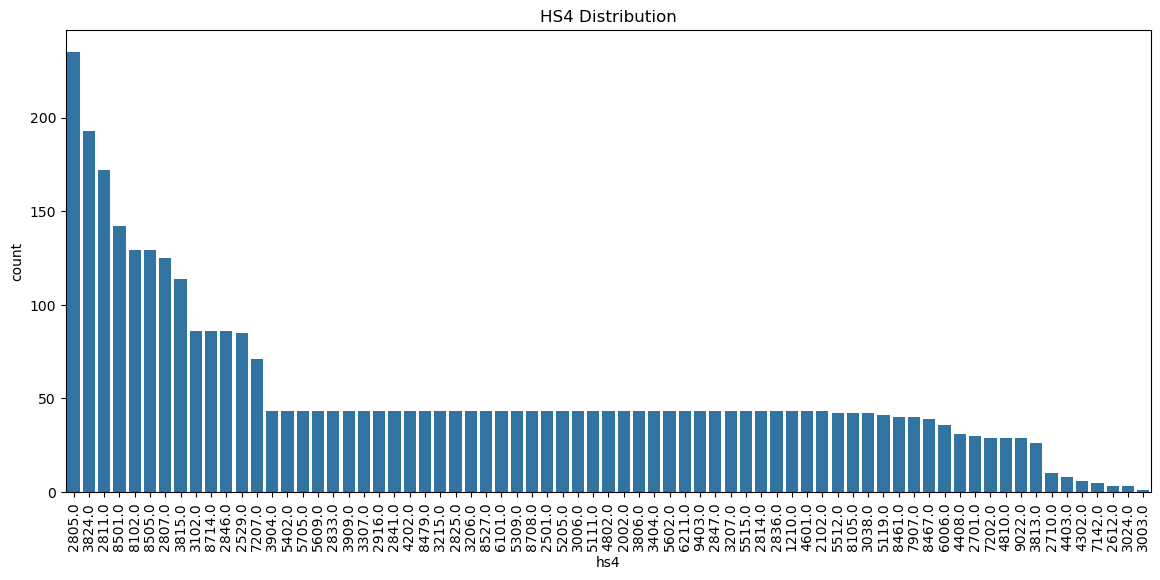

In [13]:
# HS4 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.countplot(data=df, x="hs4", order=df["hs4"].value_counts().index)
plt.xticks(rotation=90)
plt.title("HS4 Distribution")
plt.show()

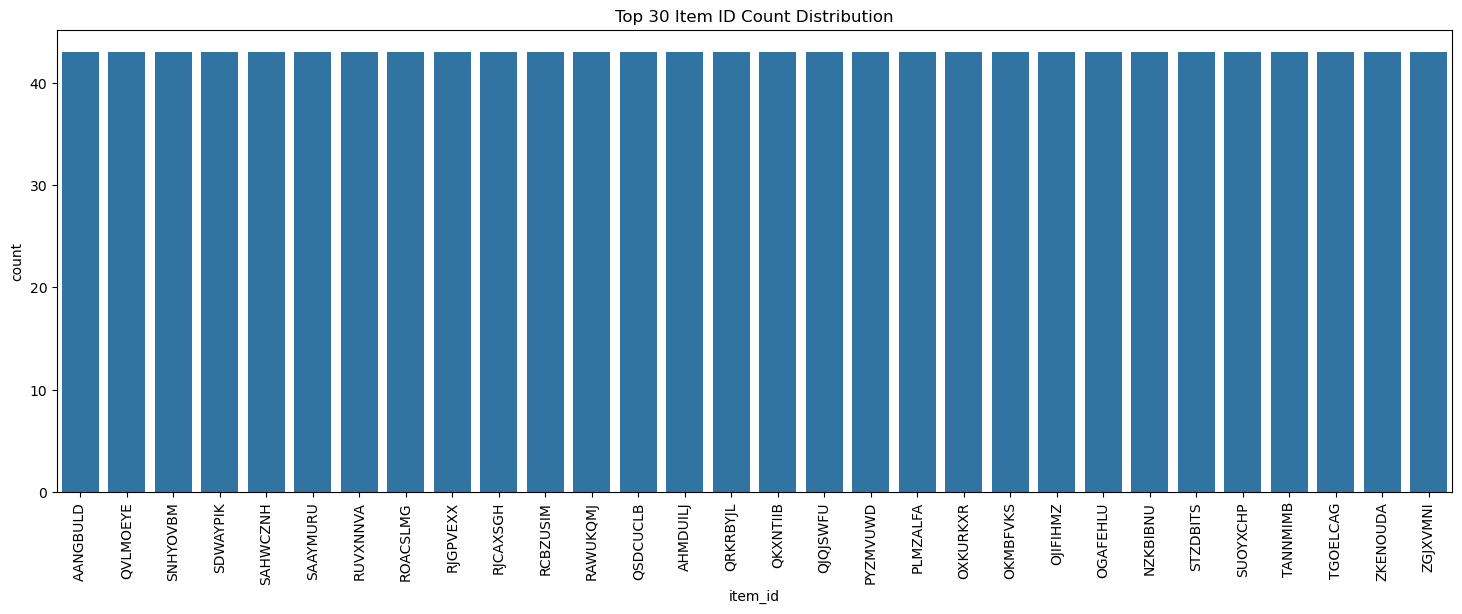

In [14]:
# item_id 분포 시각화

plt.figure(figsize=(18,6))
sns.countplot(data=df, x="item_id", order=df["item_id"].value_counts().index[:30])
plt.xticks(rotation=90)
plt.title("Top 30 Item ID Count Distribution")
plt.show()

## 3. item_id Micro-level Deep Dive

- item_id 5~10개 랜덤 추출
- 월별 value / weight / quantity 시계열 패턴 분석
- zero 패턴(0 비율) 분석
- 결측 패턴(NaN 비율) 분석
- 급증/급감(anomaly) 탐지
- HS 코드 cross-check (item_id에 여러 HS4가 존재하는지)
- 각 item_id별 상세 그래프 자동 생성(멀티 플롯)

In [15]:
import numpy as np

# df_panel 기준 사용
df = df_panel.copy()

# 8개 랜덤 sample
sample_items = np.random.choice(df['item_id'].unique(), size=8, replace=False)
sample_df = df[df['item_id'].isin(sample_items)]

monthly_trend = (
    sample_df.groupby(['item_id', 'date'])
             [['value', 'weight', 'quantity']]
             .sum()
             .reset_index()
)

monthly_trend.head()

,item_id,date,value,weight,quantity
0,AANGBULD,2022-01-01,14276.0,17625.0,0.0
1,AANGBULD,2022-02-01,52347.0,67983.0,0.0
2,AANGBULD,2022-03-01,53549.0,69544.0,0.0
3,AANGBULD,2022-04-01,0.0,0.0,0.0
4,AANGBULD,2022-05-01,26997.0,34173.0,0.0


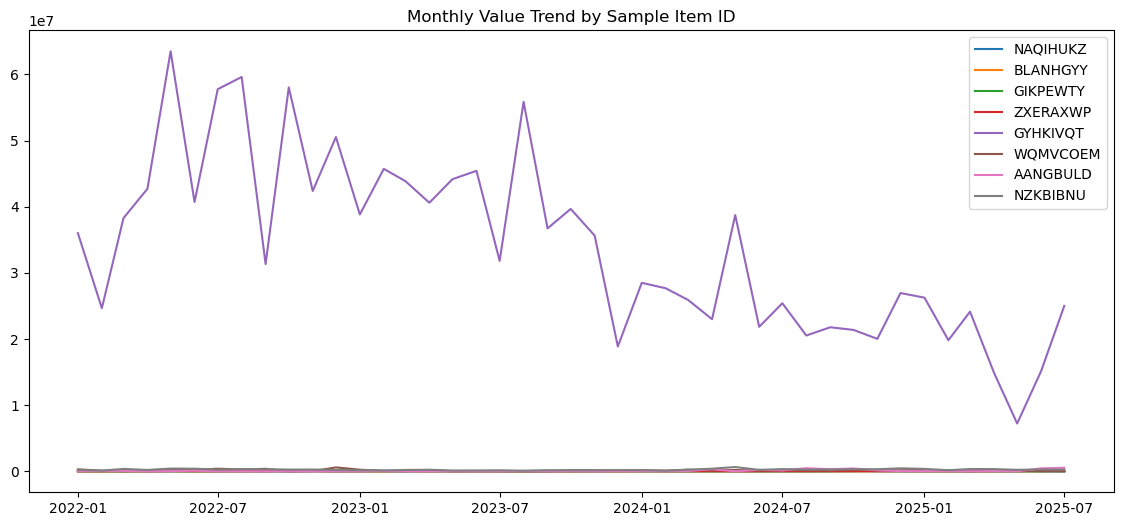

,item_id,date,value,weight,quantity


In [16]:
# 8개 item value 변화 시계열 그래프
plt.figure(figsize=(14,6))
for item in sample_items:
    tmp = monthly_trend[monthly_trend['item_id'] == item]
    plt.plot(tmp['date'], tmp['value'], label=item)

plt.title("Monthly Value Trend by Sample Item ID")
plt.legend()
plt.show()

monthly_trend[monthly_trend['item_id'] == 'GKQIJYDH']

In [17]:
df.head()
df.duplicated().sum()

0

In [18]:
# Zero / Missing 패턴 분석
zero_missing_stats = (
    df[df['item_id'].isin(sample_items)]
    .groupby('item_id')[['value_zero', 'weight_zero', 'quantity_zero',
                         'value_missing', 'weight_missing', 'quantity_missing']]
    .mean()
    .reset_index()
)

zero_missing_stats

KeyError: "Columns not found: 'value_missing', 'quantity_zero', 'value_zero', 'weight_zero', 'weight_missing', 'quantity_missing'"

In [19]:
#급증/급감 패턴(anomaly) 탐지
monthly_trend = monthly_trend.sort_values(['item_id', 'date'])

# 전월 대비 변화율
monthly_trend['value_pct_change'] = (
    monthly_trend.groupby('item_id')['value'].pct_change()
)

# 급증 top 5, 급감 bottom 5
top_spikes = monthly_trend.sort_values('value_pct_change', ascending=False).head(5)
bottom_spikes = monthly_trend.sort_values('value_pct_change', ascending=True).head(5)

top_spikes, bottom_spikes

(      item_id       date     value    weight  quantity  value_pct_change
 192  NAQIHUKZ 2023-09-01    6669.0       2.0       0.0               inf
 29   AANGBULD 2024-06-01  218073.0  400134.0       0.0               inf
 187  NAQIHUKZ 2023-04-01    9000.0      24.0       0.0               inf
 185  NAQIHUKZ 2023-02-01   12883.0      16.0       0.0               inf
 39   AANGBULD 2025-04-01   38441.0   49050.0       0.0               inf,
       item_id       date  value  weight  quantity  value_pct_change
 191  NAQIHUKZ 2023-08-01    0.0     0.0       0.0              -1.0
 40   AANGBULD 2025-05-01    0.0     0.0       0.0              -1.0
 212  NAQIHUKZ 2025-05-01    0.0     0.0       0.0              -1.0
 209  NAQIHUKZ 2025-02-01    0.0     0.0       0.0              -1.0
 45   BLANHGYY 2022-03-01    0.0     0.0       0.0              -1.0)

In [20]:
# HS 코드 cross-check (item_id -> hs4 mapping consistency)
item_hs_check = (
    df.groupby('item_id')['hs4']
      .nunique()
      .reset_index(name='hs4_count')
)

# HS4가 여러 개 존재하는 item만 추출
item_hs_issue = item_hs_check[item_hs_check['hs4_count'] > 1]

item_hs_issue

,item_id,hs4_count


In [21]:
df.duplicated().sum()

0

In [22]:
(item_hs_check['hs4_count'] > 1).sum()
df[df['item_id'] == df['item_id'].iloc[0]][['item_id','hs4']].drop_duplicates()

,item_id,hs4
0,AANGBULD,4810.0
3,AANGBULD,NaN


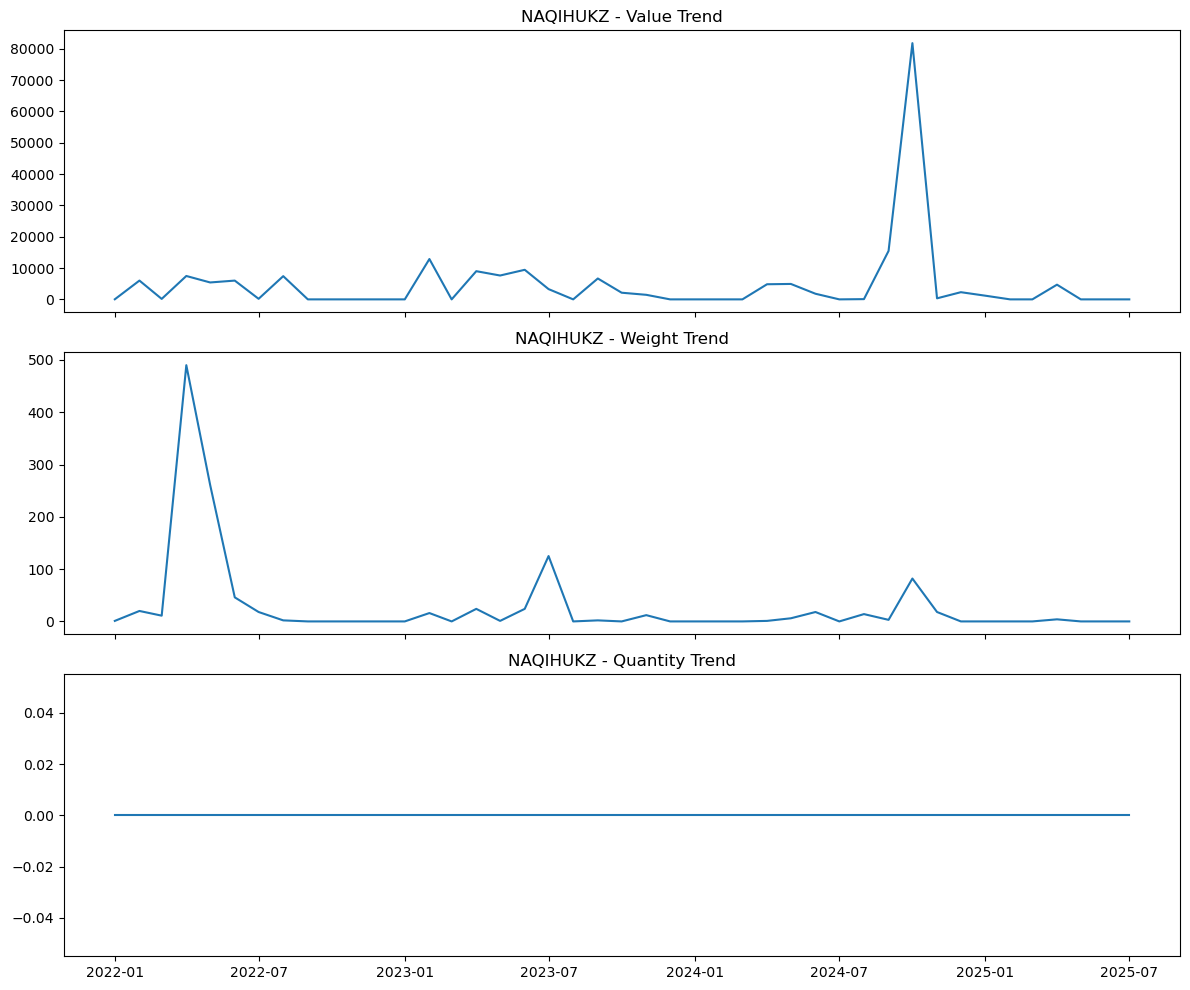

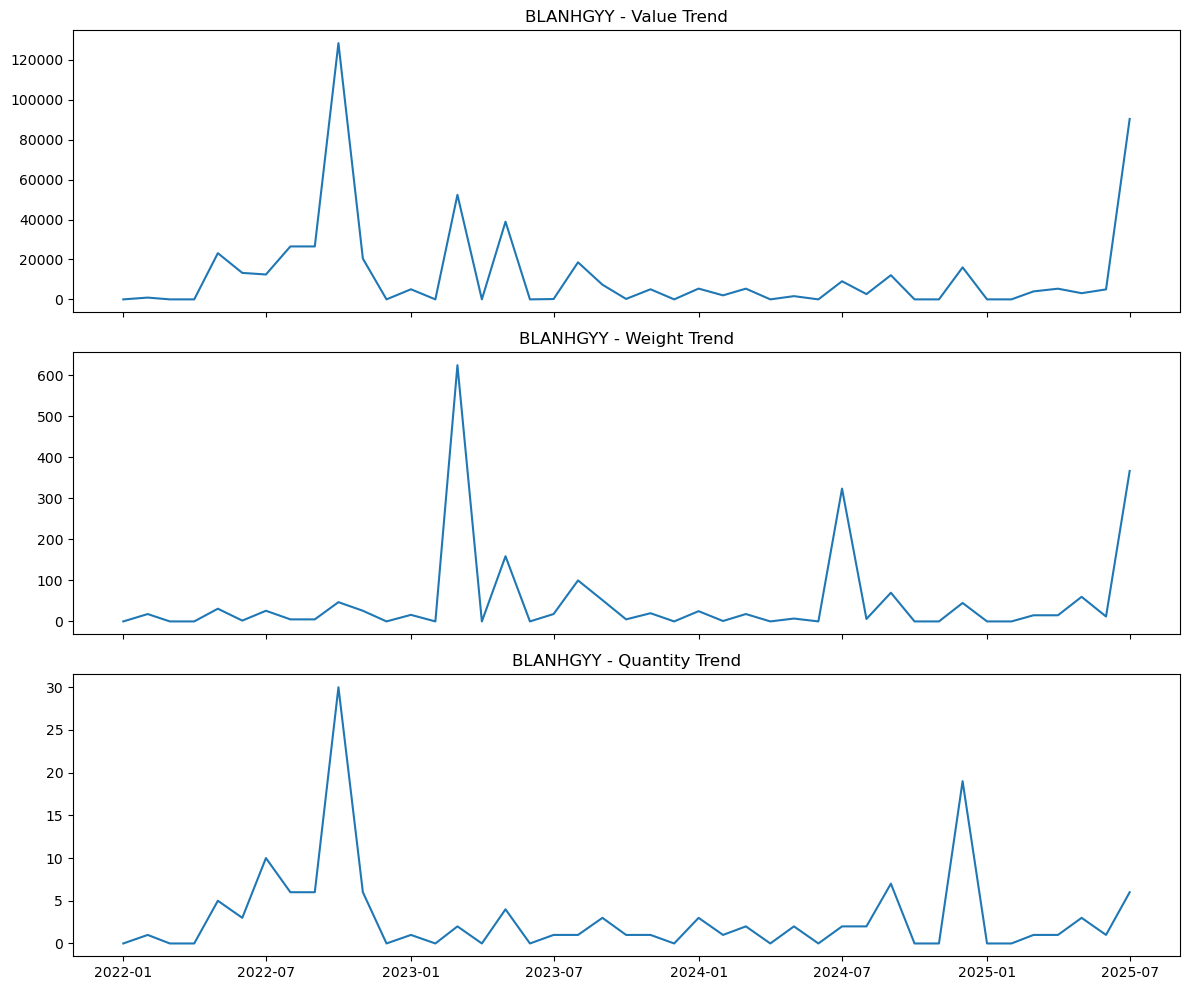

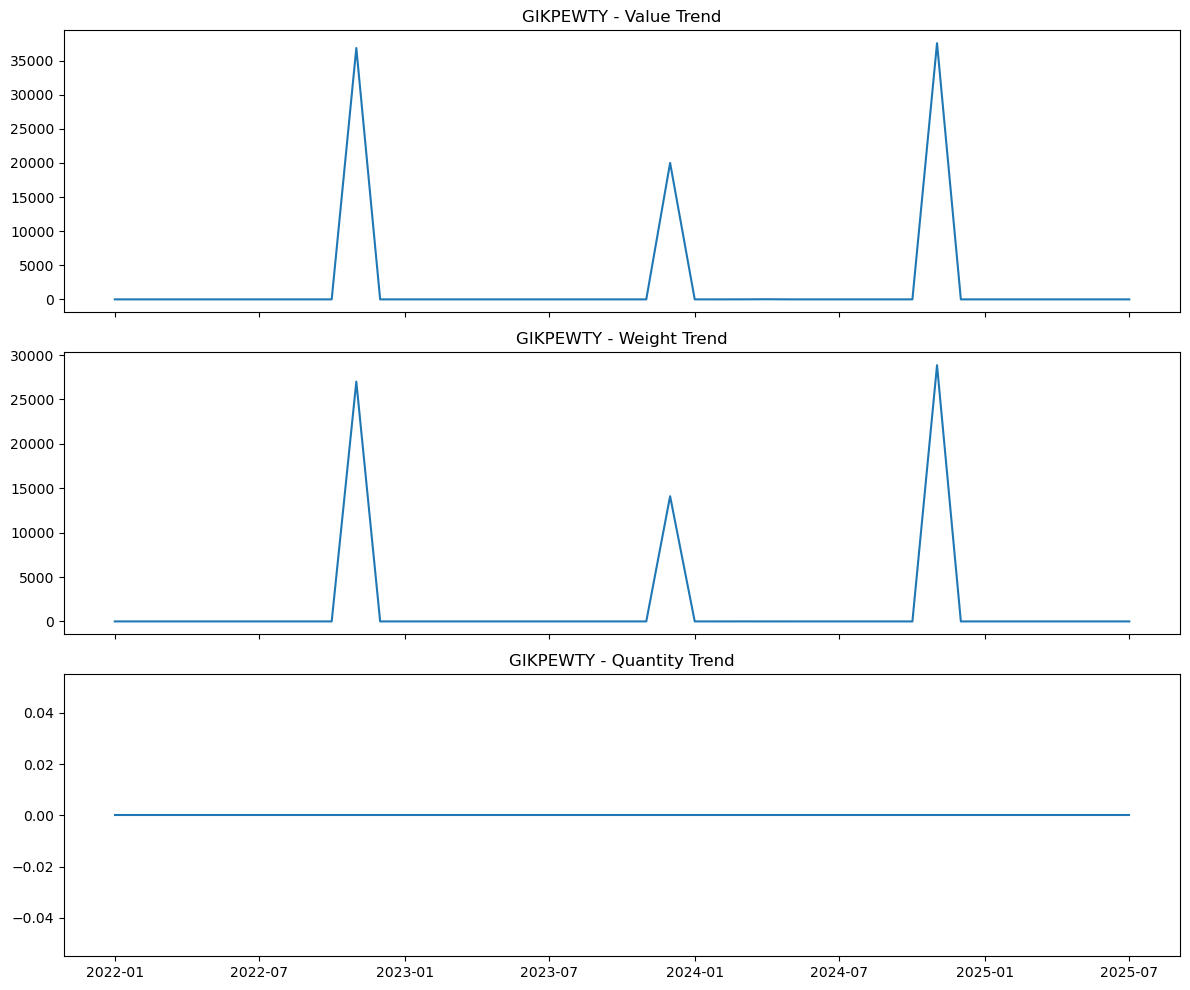

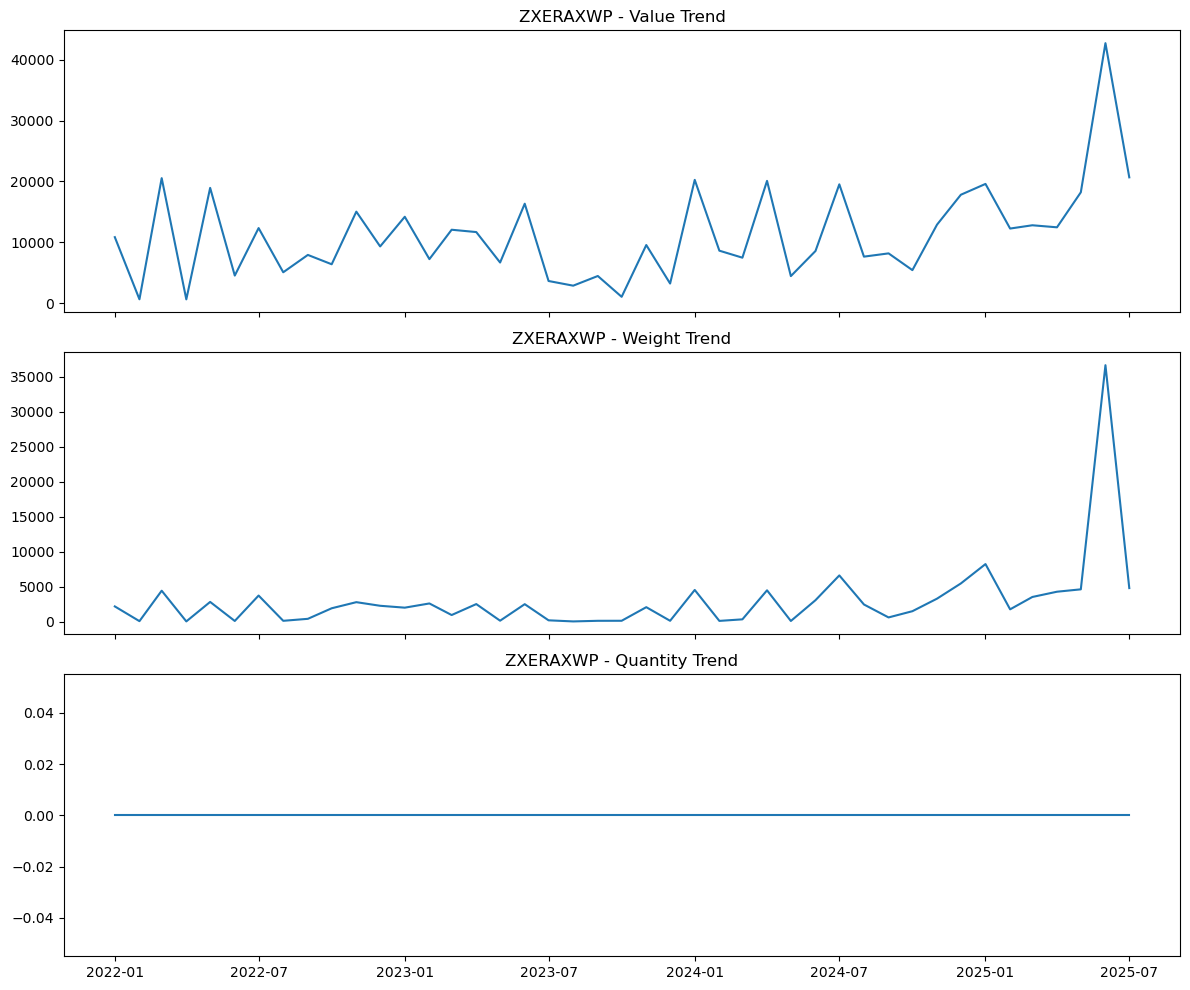

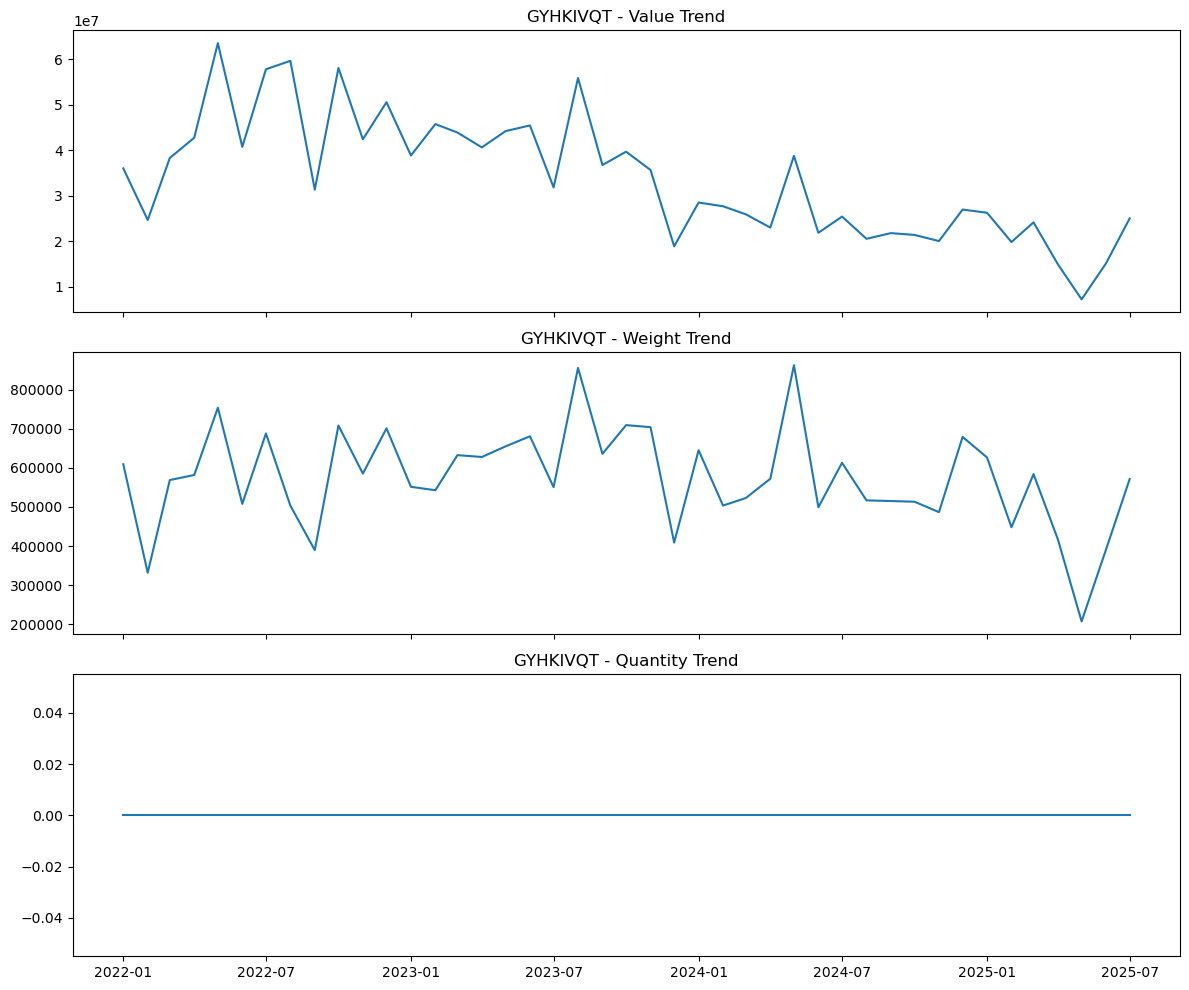

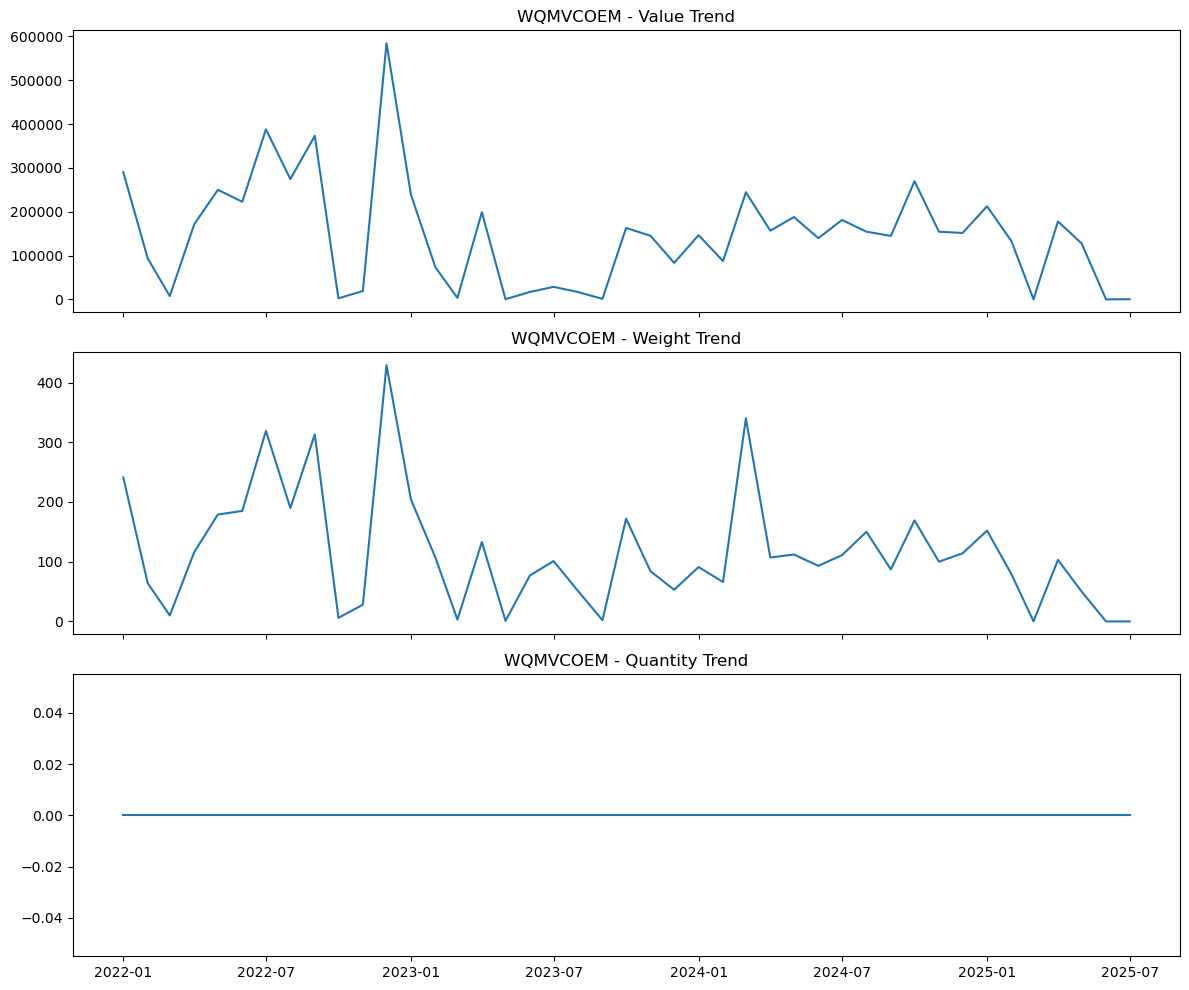

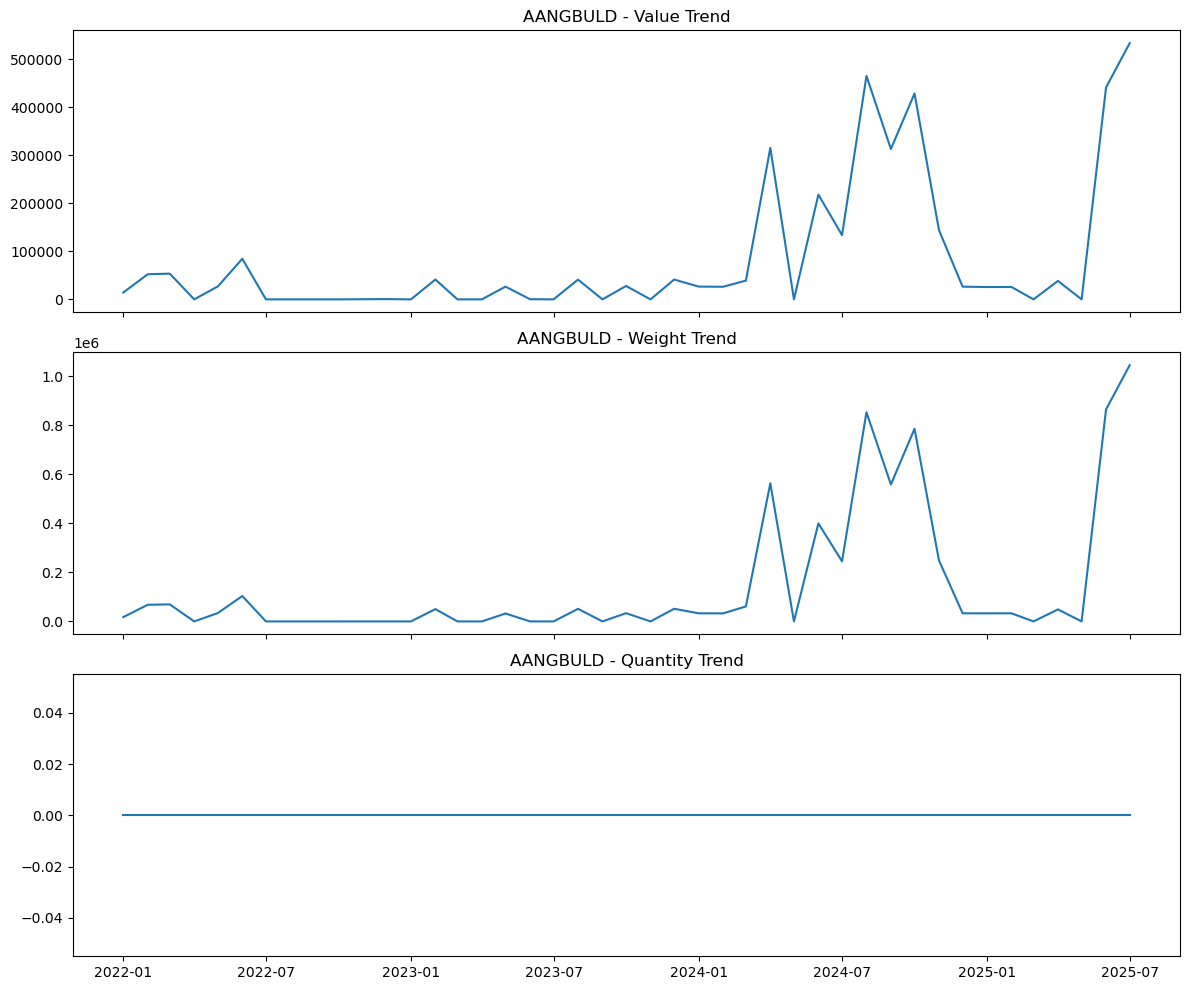

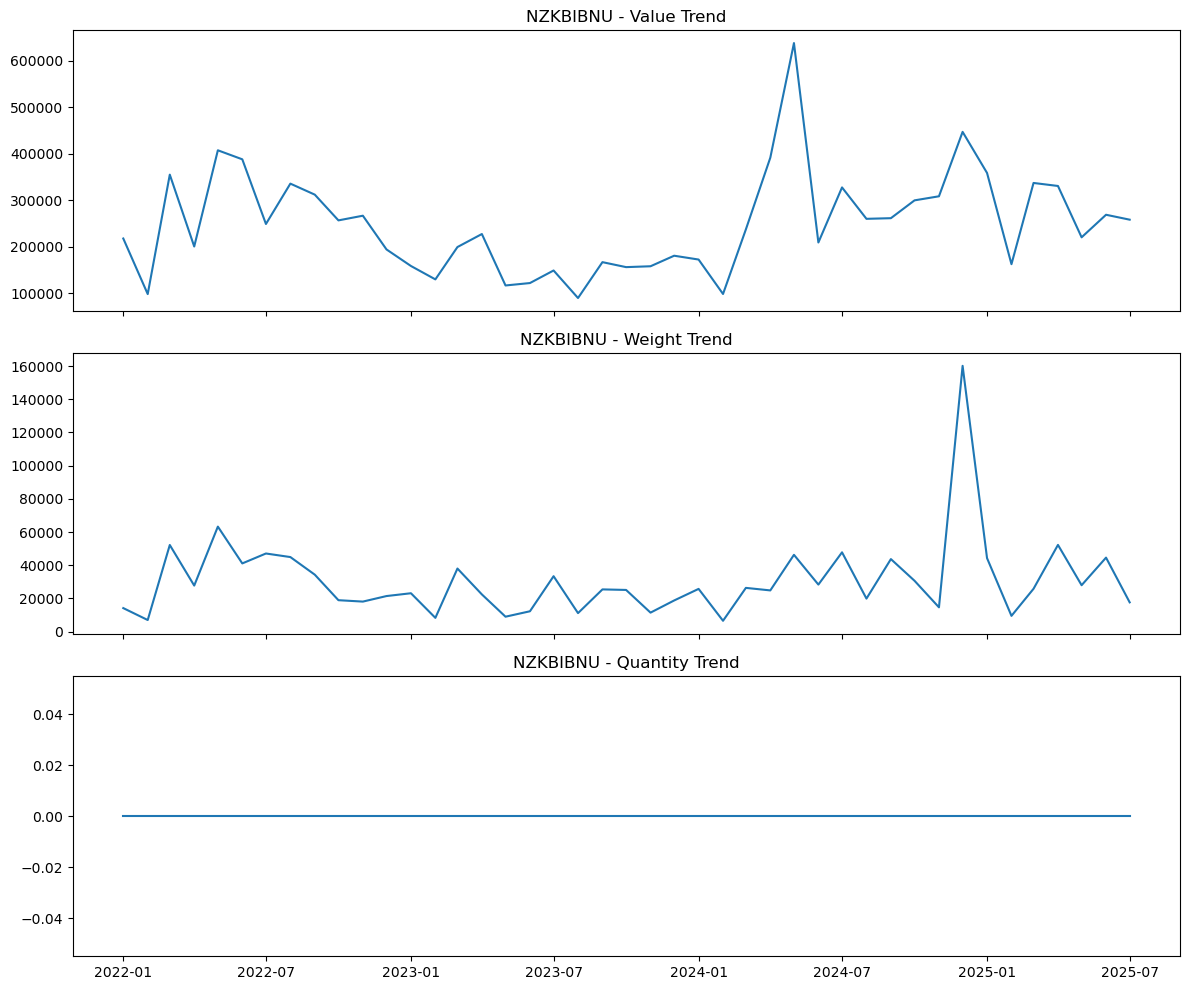

In [23]:
# 각 item_id별 상세 그래프 자동 생성 (value/weight/quantity)
for item in sample_items:
    tmp = monthly_trend[monthly_trend['item_id'] == item]

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    axes[0].plot(tmp['date'], tmp['value'])
    axes[0].set_title(f"{item} - Value Trend")

    axes[1].plot(tmp['date'], tmp['weight'])
    axes[1].set_title(f"{item} - Weight Trend")

    axes[2].plot(tmp['date'], tmp['quantity'])
    axes[2].set_title(f"{item} - Quantity Trend")

    plt.tight_layout()
    plt.show()

# 추가 전처리 부분

## 로그변환 추가

In [27]:
for col in ["value", "weight", "quantity"]:
    df_panel[f"log_{col}"] = np.log1p(df_panel[col])
    
df_panel[["log_value", "log_weight", "log_quantity"]].describe()

,log_value,log_weight,log_quantity
count,4300.000000,4300.000000,4300.000000
mean,11.120528,8.803328,1.212120
std,5.025249,5.071529,3.156326
min,0.000000,0.000000,0.000000
25%,9.587112,5.914851,0.000000
50%,12.357354,9.543628,0.000000
75%,14.649966,12.574170,0.000000
max,18.800601,18.925770,20.490843


## 시계열 피처 생성

- value_lag1, weight_lag1 → 전월 흐름 반영

- value_roll3_mean → 단기 트렌드(최근 3개월 평균) 반영

In [30]:
df_panel = df_panel.sort_values(["item_id", "date"])

group = df_panel.groupby("item_id")

# 1개월 전 값 (lag)
for col in ["value", "weight"]:
    df_panel[f"{col}_lag1"] = group[col].shift(1)
    df_panel[f"{col}_lag2"] = group[col].shift(2)

# 3개월 이동평균
for col in ["value", "weight"]:
    df_panel[f"{col}_roll3_mean"] = group[col].transform(
        lambda x: x.rolling(3, min_periods=1).mean()
    )

In [31]:
df_panel

,item_id,date,hs4,value,weight,quantity,year,month,hs2,hs2_name_kr,log_value,log_weight,log_quantity,value_lag1,value_lag2,weight_lag1,weight_lag2,value_roll3_mean,weight_roll3_mean
0,AANGBULD,2022-01-01,4810.0,14276.0,17625.0,0.0,2022,1,48,지·판지,9.566405,9.777130,0.0,NaN,NaN,NaN,NaN,14276.000000,17625.000000
1,AANGBULD,2022-02-01,4810.0,52347.0,67983.0,0.0,2022,2,48,지·판지,10.865669,11.127028,0.0,14276.0,NaN,17625.0,NaN,33311.500000,42804.000000
2,AANGBULD,2022-03-01,4810.0,53549.0,69544.0,0.0,2022,3,48,지·판지,10.888371,11.149729,0.0,52347.0,14276.0,67983.0,17625.0,40057.333333,51717.333333
3,AANGBULD,2022-04-01,NaN,0.0,0.0,0.0,2022,4,na,NaN,0.000000,0.000000,0.0,53549.0,52347.0,69544.0,67983.0,35298.666667,45842.333333
4,AANGBULD,2022-05-01,4810.0,26997.0,34173.0,0.0,2022,5,48,지·판지,10.203518,10.439220,0.0,0.0,53549.0,0.0,69544.0,26848.666667,34572.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4295,ZXERAXWP,2025-03-01,4802.0,12817.0,3507.0,0.0,2025,3,48,지·판지,9.458606,8.162801,0.0,12279.0,19599.0,1740.0,8208.0,14898.333333,4485.000000
4296,ZXERAXWP,2025-04-01,4802.0,12482.0,4258.0,0.0,2025,4,48,지·판지,9.432123,8.356790,0.0,12817.0,12279.0,3507.0,1740.0,12526.000000,3168.333333
4297,ZXERAXWP,2025-05-01,4802.0,18224.0,4598.0,0.0,2025,5,48,지·판지,9.810550,8.433594,0.0,12482.0,12817.0,4258.0,3507.0,14507.666667,4121.000000
4298,ZXERAXWP,2025-06-01,4802.0,42690.0,36632.0,0.0,2025,6,48,지·판지,10.661743,10.508705,0.0,18224.0,12482.0,4598.0,4258.0,24465.333333,15162.666667


## 거래 유무 / 결측 구분: “거래 자체가 없던 달” 표시

In [40]:
# 1) 거래 유무 플래그
df_panel["has_trade"] = (~df_panel["value"].isna()).astype(int)

# 2) 거래가 없던 달은 value/weight/quantity 전부 NaN일 가능성이 큼
# → 이때만 따로 is_no_record 플래그
df_panel["no_record"] = (
    df_panel[["value", "weight", "quantity"]].isna().all(axis=1)
).astype(int)

df_panel[["item_id", "date", "value", "weight", "quantity", "has_trade", "no_record"]].head()
## 위에 결측값 처리 반영 해야함

,item_id,date,value,weight,quantity,has_trade,no_record
0,AANGBULD,2022-01-01,14276.0,17625.0,0.0,1,0
1,AANGBULD,2022-02-01,52347.0,67983.0,0.0,1,0
2,AANGBULD,2022-03-01,53549.0,69544.0,0.0,1,0
3,AANGBULD,2022-04-01,0.0,0.0,0.0,1,0
4,AANGBULD,2022-05-01,26997.0,34173.0,0.0,1,0


## 수량(quantity) 관련

In [47]:
# 수량이 실제로 기록된 비율 (value>0 & quantity>0)
qty_usage_item = (
    df_panel
    .groupby("item_id")
    .apply(lambda g: ( (g["quantity"] > 0) & (~g["quantity"].isna()) ).mean())
    .reset_index(name="quantity_usage_rate")
)

qty_usage_item.sort_values("quantity_usage_rate", ascending=False).head()
qty_usage_item["quantity_usage_rate"].describe()


count    100.000000
mean       0.163488
std        0.355891
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: quantity_usage_rate, dtype: float64

##

In [50]:
# 월별 평균 value (전체 item 합)
monthly_mean = (
    df_panel.groupby("date")["value"]
            .mean()
            .reset_index()
)

# 연도/월로 나눠서 평균
ym_mean = (
    df_panel.groupby(["year", "month"])["value"]
            .mean()
            .reset_index()
            .sort_values(["year", "month"])
)

ym_mean

,year,month,value
0,2022,1,6965347.44
1,2022,2,5389118.79
2,2022,3,6071778.01
3,2022,4,5911707.83
4,2022,5,6263009.13
5,2022,6,4681019.38
6,2022,7,5585358.97
7,2022,8,5647902.29
8,2022,9,4099119.45
9,2022,10,4452734.66


## item별 시계열 요약 피처 (클러스터용)

In [32]:
item_ids = df_panel["item_id"].unique()
features = []

def cv(x):
    m = x.mean()
    return np.nan if m == 0 else x.std() / m

for item in item_ids:
    sub = df_panel[df_panel["item_id"] == item].sort_values("date").copy()
    sub["t"] = np.arange(len(sub))
    
    f = {}
    f["item_id"] = item
    f["mean_log_value"]   = sub["log_value"].mean()
    f["cv_log_value"]     = cv(sub["log_value"])
    f["mean_log_weight"]  = sub["log_weight"].mean()
    f["cv_log_weight"]    = cv(sub["log_weight"])
    f["value_zero_ratio"]    = (sub["value"] == 0).mean()
    f["weight_zero_ratio"]   = (sub["weight"] == 0).mean()
    f["quantity_zero_ratio"] = (sub["quantity"] == 0).mean()
    
    # 추세(기울기)
    a, b = np.polyfit(sub["t"], sub["log_value"], 1)
    f["slope_log_value"] = a
    
    # 내부 상관
    if sub["log_weight"].std() > 0 and sub["log_value"].std() > 0:
        f["corr_log_v_w"] = sub["log_value"].corr(sub["log_weight"])
    else:
        f["corr_log_v_w"] = 0.0

    features.append(f)

feat_df = pd.DataFrame(features)
feat_df.head()

,item_id,mean_log_value,cv_log_value,mean_log_weight,cv_log_weight,value_zero_ratio,weight_zero_ratio,quantity_zero_ratio,slope_log_value,corr_log_v_w
0,AANGBULD,7.175608,0.737168,7.276292,0.760689,0.325581,0.325581,1.000000,0.136385,0.995652
1,AHMDUILJ,11.671430,0.037132,10.563792,0.063015,0.000000,0.000000,1.000000,-0.004881,0.927627
2,ANWUJOKX,1.948870,2.122247,2.020651,2.121435,0.813953,0.813953,0.813953,-0.101423,0.999935
3,APQGTRMF,11.421845,0.229799,9.731180,0.259494,0.023256,0.023256,1.000000,-0.116734,0.984970
4,ATLDMDBO,17.779741,0.028465,18.412748,0.013428,0.000000,0.000000,1.000000,-0.027216,0.548317


- mean_log_value / mean_log_weight
→ 이 item은 평균적으로 어느 정도 규모의 품목인가?
(고액/고중량 vs 소액/소중량)

- cv_log_value / cv_log_weight (변동계수)
→ 월별 값이 얼마나 출렁거리는지

- CV ↑ : 스파이크 많은, 불안정한 품목
CV ↓ : 꾸준한 정기 거래 품목

- value_zero_ratio / weight_zero_ratio / quantity_zero_ratio
→ 이 item은 거래 없는 달이 얼마나 많은지,
특히 quantity는 “수량을 기록하는 품목인지, 아예 안 적는 품목인지” 구분 가능

- slope_log_value
→ 시계열이 **우상향(성장형)**인지, **우하향(줄어드는 품목)**인지 / 양수면 시간이 갈수록 value 커짐 / 음수면 점점 줄어드는 품목

- corr_log_v_w
→ 이 품목에서 무게와 금액이 얼마나 같이 움직이는지/ 1에 가까우면 “무게만 봐도 금액 예측 가능(단가 안정형)”/ 낮으면 “같은 무게인데도 금액이 들쭉날쭉(고단가/스펙 영향 큰 품목)”

## 클러스터 생성

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1) 숫자 컬럼만 선택 (item_id는 제외)
num_cols = feat_df.select_dtypes(include=["float64", "int64"]).columns.tolist()
if "item_id" in num_cols:
    num_cols.remove("item_id")

X = feat_df[num_cols].copy()
X = X.fillna(0.0)   # NaN 있으면 0으로

# 2) 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) KMeans 군집 (n_init은 정수)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

# ✅ 여기서 괄호 꼭 닫혀야 함! X_scaled 쓰는 거 주의
feat_df["cluster"] = kmeans.fit_predict(X_scaled)

# 4) 결과 확인
print(feat_df["cluster"].value_counts())
feat_df[["item_id", "cluster"]].head()

cluster
1    59
0    17
2    15
3     9
Name: count, dtype: int64


,item_id,cluster
0,AANGBULD,0
1,AHMDUILJ,1
2,ANWUJOKX,3
3,APQGTRMF,1
4,ATLDMDBO,1


일단 이건 무시↓

In [ ]:
from sklearn.cluster import KMeans
inertia_arr=[]
k_range=range(2,8)

for k in k_range:
    kmeans=KMeans(n_cluster=k, random_state=42)
    kmeans.fit(df)
    inertia=kmeans,inertia_
    
    print('k:',k, 'inertia:',inertia)
    
    inertia_arr.append(inertia)
inertia_arr=np.array(inertia_arr)

In [38]:
# item_id - cluster만 뽑기
item_cluster = feat_df[["item_id", "cluster"]]

# df_panel에 붙이기
df_panel = df_panel.merge(item_cluster, on="item_id", how="left")

# 확인용
df_panel[["item_id", "date", "value", "cluster"]].head()

,item_id,date,value,cluster
0,AANGBULD,2022-01-01,14276.0,0
1,AANGBULD,2022-02-01,52347.0,0
2,AANGBULD,2022-03-01,53549.0,0
3,AANGBULD,2022-04-01,0.0,0
4,AANGBULD,2022-05-01,26997.0,0
